# Figure 1: Athletes Brain Study - Refactored

This notebook demonstrates the refactored, modular approach to generating Figure 1 for the athletes brain study.
The analysis has been organized into reusable modules within the `athletes_brain.fig1` package.

## Setup and Imports

Import the refactored modules from our package.

In [1]:
# Standard imports
from pathlib import Path
import pandas as pd
import numpy as np

# Import our refactored modules
from athletes_brain.fig1 import (
    Fig1Config,
    AthletesBrainDataLoader,
    GroupComparison,
    BrainPlotter,
    generate_figure1
)

# Import specific functions for focused analysis
from athletes_brain.fig1.main import (
    analyze_specific_comparison,
    get_most_significant_regions
)

2025-08-13 16:36:41.249 | INFO     | athletes_brain.config:<module>:11 - PROJ_ROOT path is: /home/galkepler/Projects/athletes_brain


## Configuration

Set up the configuration and visualization settings.

In [4]:
# Initialize configuration
config = Fig1Config()
config.METRICS = ["gm_vol"]
# Set up matplotlib configuration for consistent plots
config.setup_matplotlib_config()

# Display configuration
print(f"Atlas: {config.ATLAS}")
print(f"Metrics: {config.METRICS}")
print(f"Group labels: {config.CLIMBER_GROUP_LABEL}, {config.BJJ_GROUP_LABEL}, {config.CONTROL_GROUP_LABEL}")
print(f"P-value threshold: {config.P_THRESHOLD}")
print(f"Visualization range: [{config.VMIN}, {config.VMAX}]")

Atlas: schaefer2018tian2020_400_7
Metrics: ['gm_vol']
Group labels: Climbing, Bjj, Control
P-value threshold: 0.05
Visualization range: [-5, 5]


## Quick Analysis: Generate Complete Figure 1

Use the main function to generate all comparisons and visualizations.

In [5]:
# Generate complete Figure 1
output_dir = Path("/media/storage/phd") / "athletes_brain" / "figures" / "behavioral"
# generate_figure1(output_dir=output_dir, config=config)

## Step-by-Step Analysis

For more control, we can run each step individually using the modular components.

### 1. Data Loading

In [75]:
# Initialize data loader
data_loader = AthletesBrainDataLoader(config)

# Load all data
metric_data, parcels, nifti_path, nifti_matlab_path = data_loader.load_all_data()

print(f"Loaded {len(metric_data)} metrics")
print(f"Loaded {len(parcels)} brain parcels")
print(f"Metrics: {list(metric_data.keys())}")

# Display sample data (demographics)
df = metric_data["gm_vol"]
df["subject_code"] = (
    df["subject_code"]
    .astype(str)
    .str.replace("-", "")
    .str.replace(" ", "")
    .str.replace("_", "")
    .str.zfill(4)
)
df = df.drop_duplicates(subset=["subject_code"], keep="first")

print(f"N participants: {df.shape[0]}")


2025-08-13 17:05:12.727 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:48 - Loading metric data...
2025-08-13 17:05:12.727 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:54 - Loading gm_vol data


/home/galkepler/Projects/athletes_brain/athletes_brain/fig1/data_loader.py:57: DtypeWarning: Columns (1,8,9,10,11,12,68,74,78,79,80,81,82,84,85,86,87,92,93,94,95,96,97,99,113,116,121,122,123,124,125,132,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.processed_dir / f"{metric}.csv", index_col=0).reset_index(


2025-08-13 17:05:18.532 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:74 - Loaded 472498 records for gm_vol
2025-08-13 17:05:18.532 | SUCCESS  | athletes_brain.fig1.data_loader:load_metric_data:76 - Successfully loaded 1 metrics
2025-08-13 17:05:18.532 | INFO     | athletes_brain.fig1.data_loader:load_atlas_data:32 - Loading atlas data for schaefer2018tian2020_400_7
2025-08-13 17:05:18.534 | INFO     | athletes_brain.fig1.data_loader:load_atlas_data:39 - Loaded 454 parcels from atlas
Loaded 1 metrics
Loaded 454 brain parcels
Metrics: ['gm_vol']
N participants: 1032


In [91]:
df_cov = pd.read_csv("~/Projects/plasticityhub/sessions.csv")
df_cov["subject_code"] = (
    df_cov["subject_code"]
    .astype(str)
    .str.replace("-", "")
    .str.replace(" ", "")
    .str.replace("_", "")
)
df_cov = df_cov.drop_duplicates(subset=["subject_code"]).set_index("subject_code")

df_cov["target"] = df.set_index("subject_code")["target"]
df_cov = df_cov.dropna(subset=["target"])

In [92]:
df_cov["target"] = df_cov["target"].astype(str)
df_cov["sex"]    = df_cov["sex"].astype(str)
df_cov["age_c"]  = df_cov["age_at_scan"] - df_cov["age_at_scan"].mean()
df_cov["BMI"] = df_cov["weight"] / ((df_cov["height"]/100) ** 2)

### 2. Statistical Analysis

In [93]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

def class_balance_weights(s, target_mix=None):
    # s: Series with values "True"/"False" for athlete/control (strings)
    p_obs = s.value_counts(normalize=True).to_dict()
    if target_mix is None:
        target_mix = { "True": 0.5, "False": 0.5 }  # choose your target mix
    return s.map(lambda g: target_mix[g] / p_obs[g])

def analyze_with_class_weights(df, target_mix=None, robust=None, metric: str = "adc"):
    d = df.dropna(subset=["value","target","sex","age_at_scan"]).copy()
    d["target"] = d["target"].astype(str)
    d["sex"]    = d["sex"].astype(str)
    d["age_c"]  = d["age_at_scan"] - d["age_at_scan"].mean()
    w = class_balance_weights(d["target"], target_mix=target_mix)

    formula = ("value ~ C(target, Treatment(reference='False')) "
               "+ C(sex) + age_c + I(age_c**2)")
    if "vol" in metric:
        formula += " + tiv"
    
    fit = smf.wls(formula, data=d, weights=w).fit(cov_type=(robust or "nonrobust"))

    # effect (athletes vs controls) is the coefficient on the target indicator:
    coef_name = [k for k in fit.params.index if k.startswith("C(target")][0]
    t = fit.tvalues[coef_name]
    df_r = fit.df_resid
    r_partial = np.sign(t) * np.sqrt(t**2 / (t**2 + df_r))
    r2_partial = t**2 / (t**2 + df_r)
    out = {
        "target_mix": target_mix or {"True":0.5, "False":0.5},
        "coef_delta": float(fit.params[coef_name]),
        "t": float(t),
        "r_partial": float(r_partial),
        "r2_partial": float(r2_partial),
        "ci95": tuple(map(float, fit.conf_int().loc[coef_name])),
        "p_value": float(fit.pvalues[coef_name]),
        "n": len(d),
        # effective n is useful to report with weights:
        "effective_n": float((w.sum()**2) / (w.pow(2).sum()))
    }
    return out, fit


In [94]:
df_cov.columns.tolist()

['subject_id',
 'dob',
 'age_at_scan',
 'sex',
 'session_id',
 'study',
 'group',
 'condition',
 'path',
 'weight',
 'height',
 'filled',
 'version',
 'handedness',
 'gender',
 'sexual_orientation',
 'living_environment',
 'years_in_residence',
 'marital_status',
 'relationship_duration',
 'number_of_children',
 'number_of_siblings',
 'sibling_order',
 'twins',
 'ethnic_identity',
 'political_orientation',
 'religion',
 'religion_degree',
 'family_history',
 'blood_sugar',
 'blood_pressure',
 'thyroids',
 'lipids',
 'severe_health_conditions',
 'major_health_conditions',
 'minor_health_conditions',
 'brain_health',
 'depression',
 'anxiety',
 'communication_disorders',
 'attention_disorders',
 'visual_aid',
 'hearing_aid',
 'psqi',
 'long_covid',
 'oasis',
 'pcl5',
 'gad7',
 'phq9',
 'b5_extraversion',
 'b5_agreeableness',
 'b5_conscientiousness',
 'b5_emotional_stability',
 'b5_openness',
 'hli',
 'swls',
 'education_level',
 'salary',
 'psychometric_score',
 'main_hobby',
 'hobby_tim

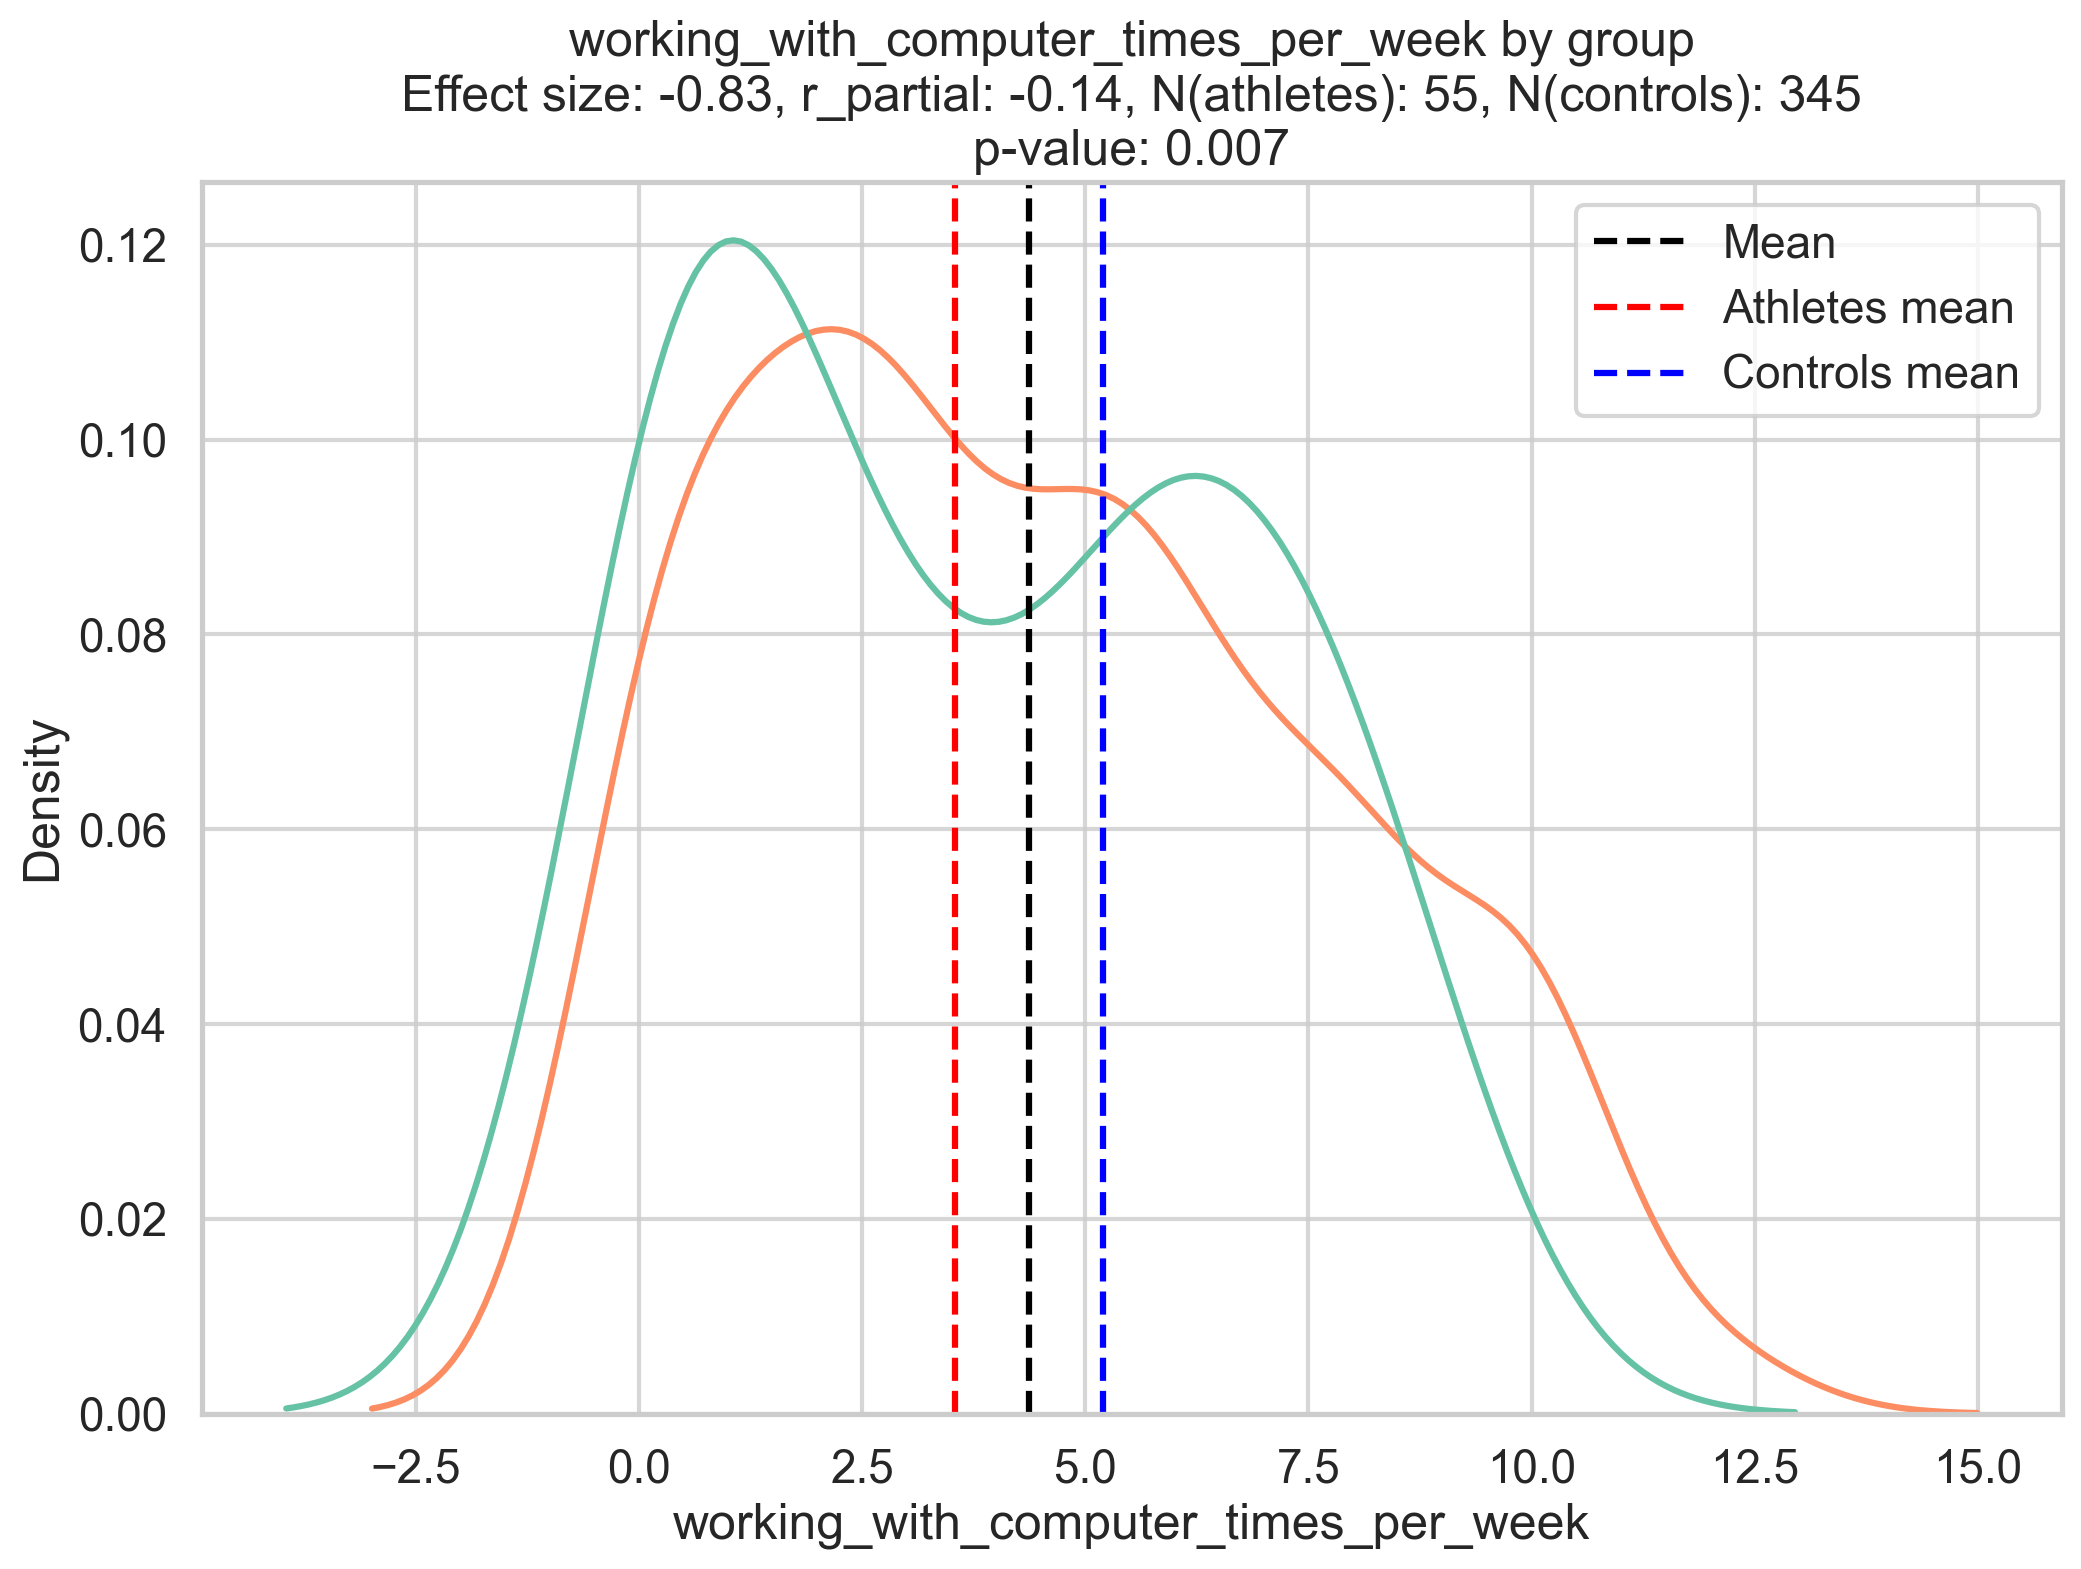

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

target_col = "working_with_computer_times_per_week"
d = df_cov.dropna(subset=[target_col])

w = class_balance_weights(d["target"].astype(str))



fit = smf.wls(f"{target_col} ~ C(target, Treatment(reference='False')) + C(sex) + age_c + I(age_c ** 2)", data=d, weights=w).fit()
fit.summary()

# get "clean" coefficients for plotting
coef_name = [k for k in fit.params.index if k.startswith("C(target")][0]
coef = fit.params[coef_name]
t = fit.tvalues[coef_name]
df_r = fit.df_resid
r_partial = np.sign(t) * np.sqrt(t**2 / (t**2 + df_r))
r2_partial = t**2 / (t**2 + df_r)

sns.kdeplot(x=target_col, hue="target", data=d, common_norm=False)
plt.axvline(d[target_col].mean(), color="black", linestyle="--", label="Mean")
plt.axvline(d[target_col].mean() + coef, color="red", linestyle="--", label="Athletes mean")
plt.axvline(d[target_col].mean() - coef, color="blue", linestyle="--", label="Controls mean")
plt.title(f"{target_col} by group\n"
          f"Effect size: {coef:.2f}, r_partial: {r_partial:.2f}, N(athletes): {d[d['target'] == 'True'].shape[0]}, "
          f"N(controls): {d[d['target'] == 'False'].shape[0]}\n"
          f"p-value: {fit.pvalues[coef_name]:.3f}")
plt.xlabel(target_col)
plt.ylabel("Density")
plt.legend()


<Axes: xlabel='BMI', ylabel='Density'>

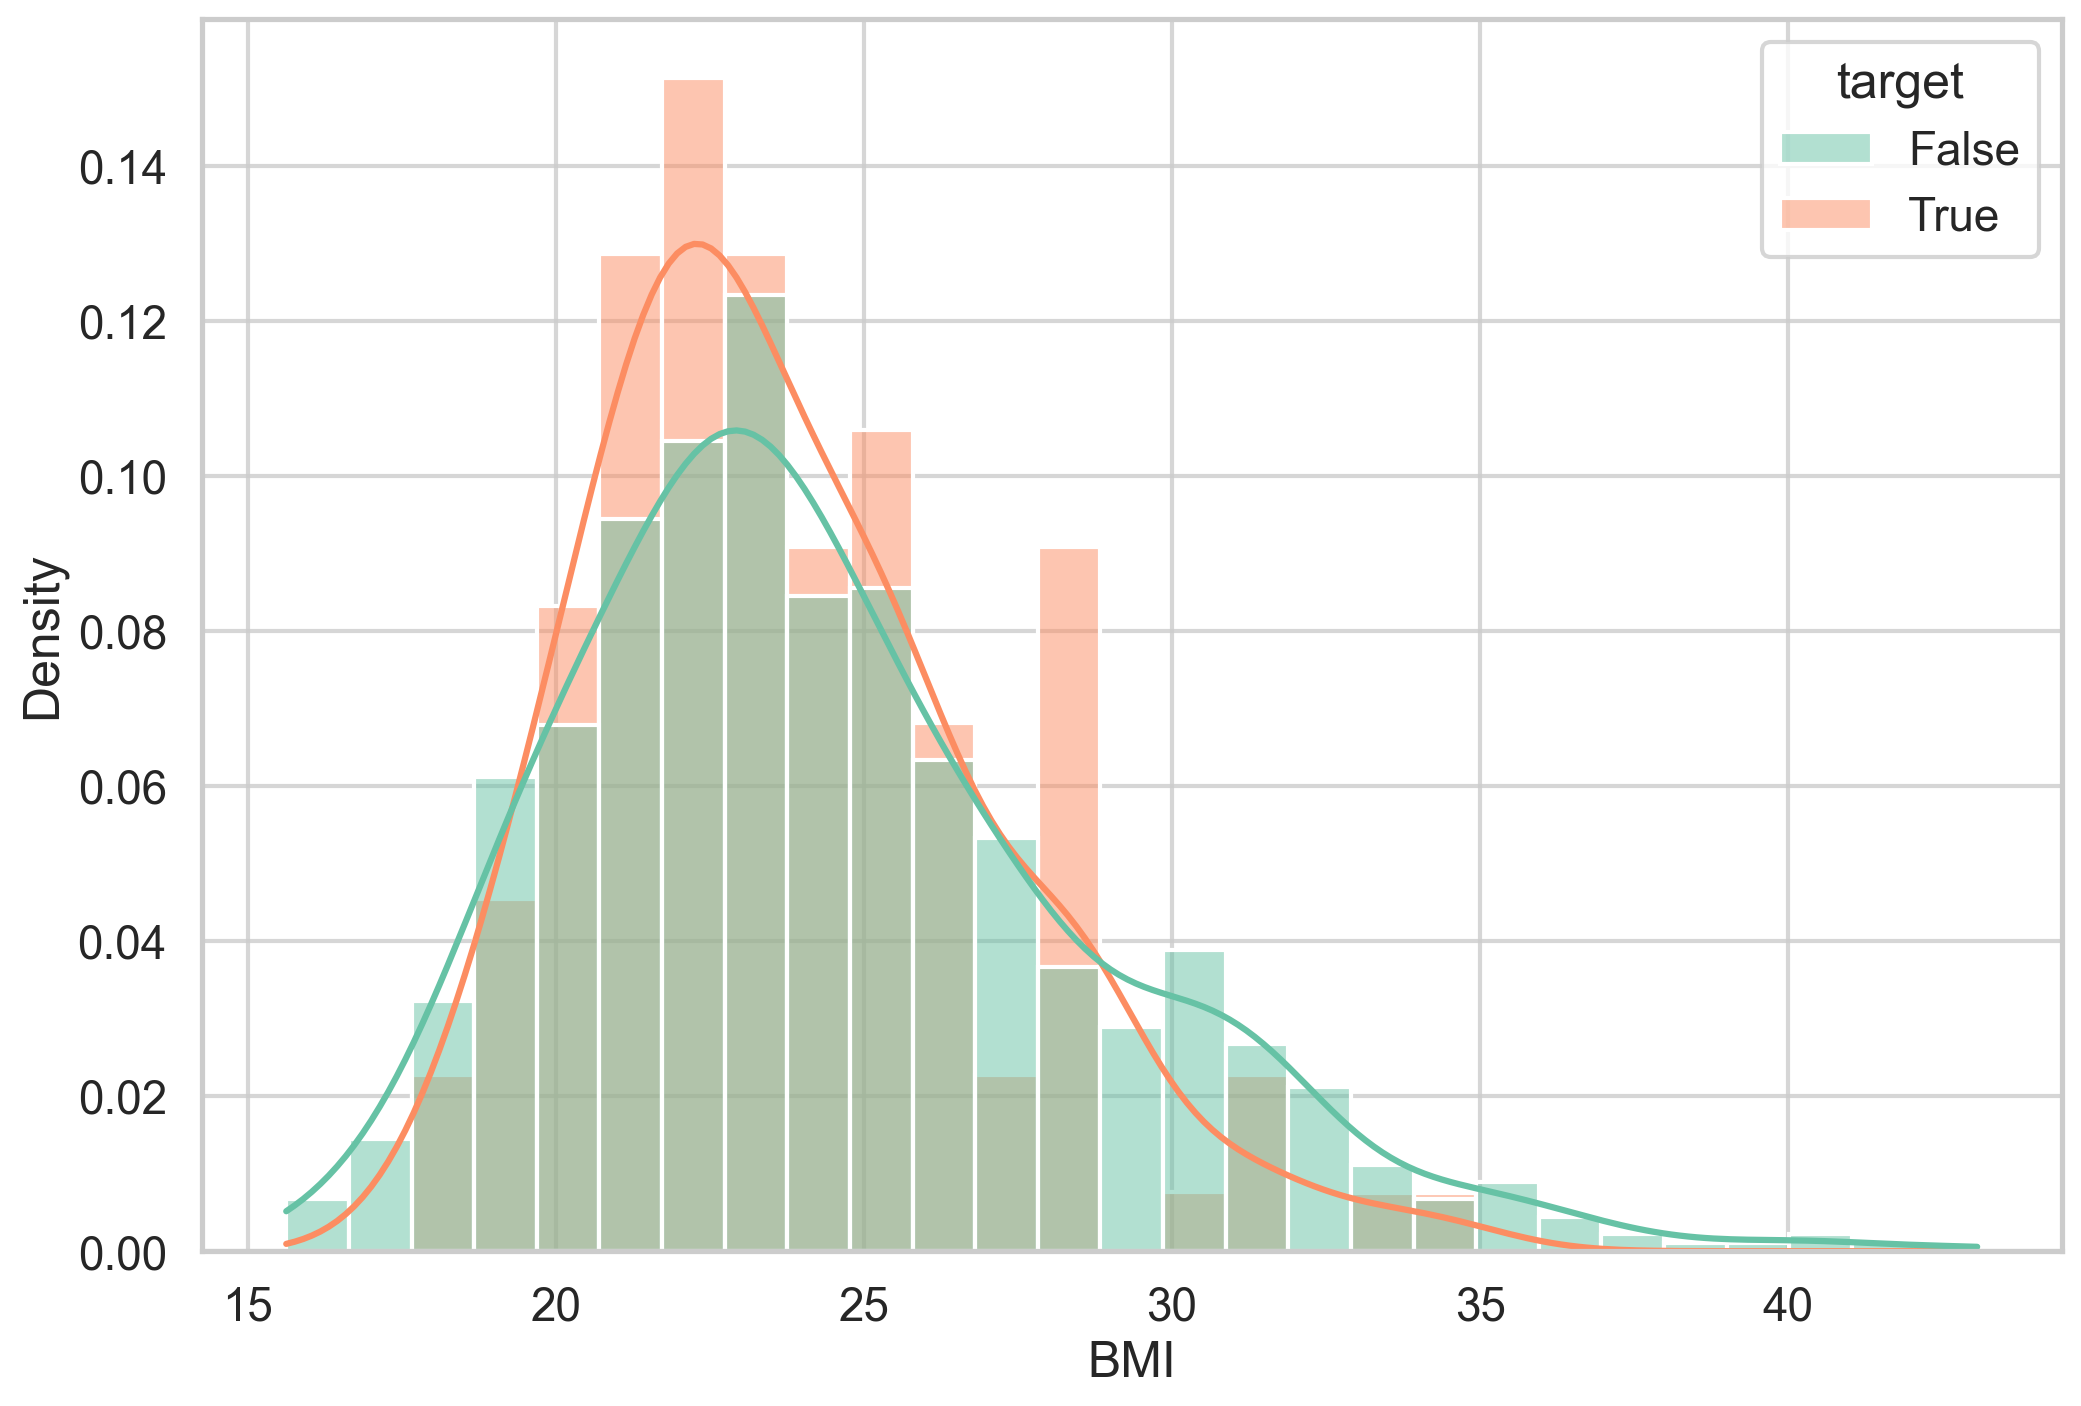

In [101]:
# sns.boxplot(x="target", y=target_col, data=df_cov, showfliers=False)
sns.histplot(x=target_col, hue="target", data=df_cov, stat="density", common_norm=False, kde=True)